# Problem 1: Random Walk Monte Carlo

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Write your own Random Walk MCMC algorithm from scratch. Don't worry if it is slow or inefficient - this exercise is about intuition building, not results. Use your sampler to fit a line to the data and generate samples from the posterior. For a first pass, run the sampler for a fixed number of steps, $N$. Then, modify the sampler to automatically stop running when a target number of effective samples $N_{\rm eff}$ has been reached.

In [13]:
%pip install emcee
%pip install dynesty
%pip install pymc3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.6/872.6 kB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 21.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 21.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee

In [3]:
tb = pd.read_csv('line_fitting.csv')
tb.head()

,Unnamed: 0,x,y,y_err
0,0,0.596779,8.112571,0.160314
1,1,0.921049,3.528151,0.513170
2,2,1.156184,4.810234,0.401530
3,3,1.754518,0.892382,0.372534
4,4,1.824917,3.132952,0.271382


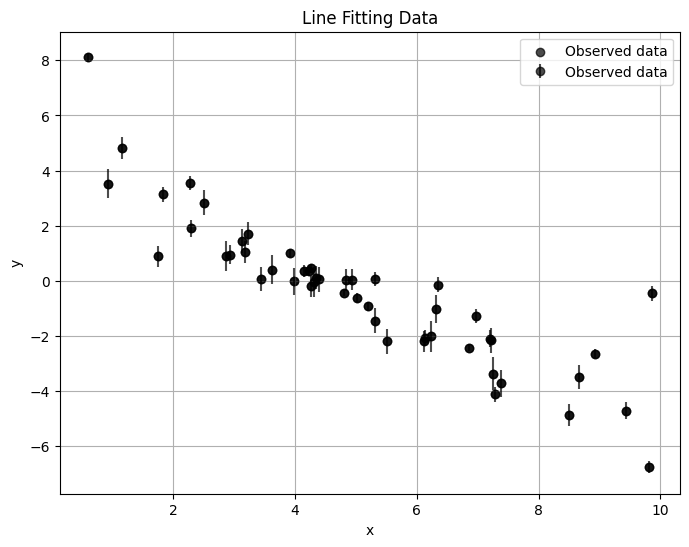

In [ ]:
x_err = np.zeros(len(tb['y_err']))

plt.figure(figsize=(8, 6))
plt.scatter(tb['x'], tb['y'], color='black', alpha=0.7, label='Observed data')
plt.errorbar(tb['x'], tb['y'], yerr = tb['y_err'], fmt='o', color='black', alpha=0.7, label='Error')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line Fitting Data')
plt.legend()
plt.grid(True)
plt.show()

### Steps to build an MCMC algo:

1. Get a model
2. Get a likelihood function
3. Get a prior 
4. Posterior = prior $\times$ likelihood
5. Setup the run for the MCMC:

    - initialize $m$, $b$
    - loop over steps
    - make proposal for $m$, $b$
    - acceptance ratio for new vs current
    - $\alpha > 1$, update the samples
    - $\alpha < 1$, reject the proposal and keep current samples

In [9]:
# Extract data
x_data = tb['x'].values
y_data = tb['y'].values
y_err = tb['y_err'].values

# Define the log likelihood
def log_likelihood(m, b):
    model = m * x_data + b
    return -0.5 * np.sum(((y_data - model) / y_err) ** 2)

# Define the prior: flat prior, return 0 if reasonable, else -inf
def log_prior(m, b):
    if -10 < m < 10 and -10 < b < 10:
        return 0.0
    return -np.inf

# Define the posterior
def log_posterior(m, b):
    lp = log_prior(m, b)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(m, b)

# Random Walk MCMC Sampler
def run_mcmc(init_m, init_b, n_steps=10000, step_size=0.1):
    samples = []
    m_current, b_current = init_m, init_b
    log_post_current = log_posterior(m_current, b_current)

    for _ in range(n_steps):
        m_proposal = np.random.normal(m_current, step_size)
        b_proposal = np.random.normal(b_current, step_size)
        log_post_proposal = log_posterior(m_proposal, b_proposal)

        accept_prob = np.exp(log_post_proposal - log_post_current)
        if np.random.rand() < accept_prob:
            m_current, b_current = m_proposal, b_proposal
            log_post_current = log_post_proposal
        
        samples.append([m_current, b_current])
    
    return np.array(samples)

In [10]:
# Run the MCMC sampler
np.random.seed(42)
samples = run_mcmc(init_m=0.0, init_b=0.0, n_steps=10000, step_size=0.05)

samples[:5]  # show first few samples

array([[ 0.        ,  0.        ],
       [-0.05559401,  0.01594511],
       [-0.05559401,  0.01594511],
       [-0.08463791, -0.01031338],
       [-0.08463791, -0.01031338]])

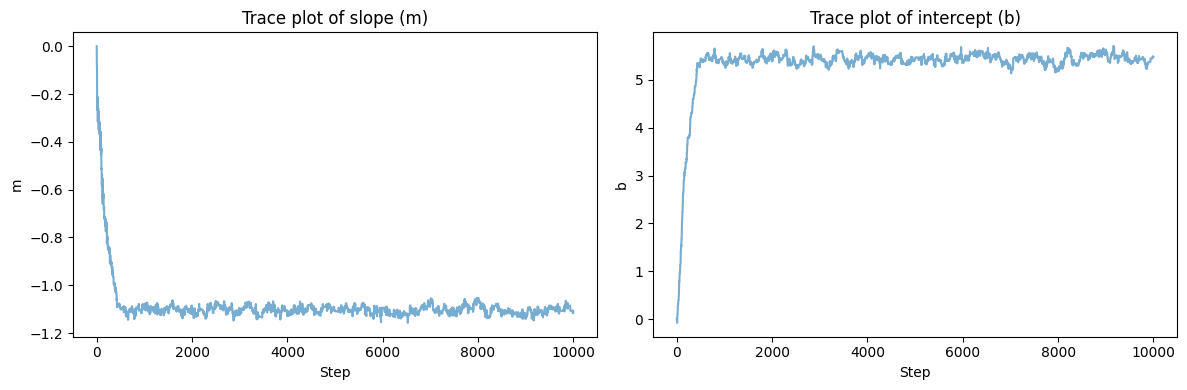

In [11]:
# Trace plots
m_samples = samples[:, 0]
b_samples = samples[:, 1]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(m_samples, alpha=0.6)
plt.title("Trace plot of slope (m)")
plt.xlabel("Step")
plt.ylabel("m")

plt.subplot(1, 2, 2)
plt.plot(b_samples, alpha=0.6)
plt.title("Trace plot of intercept (b)")
plt.xlabel("Step")
plt.ylabel("b")

plt.tight_layout()
plt.show()

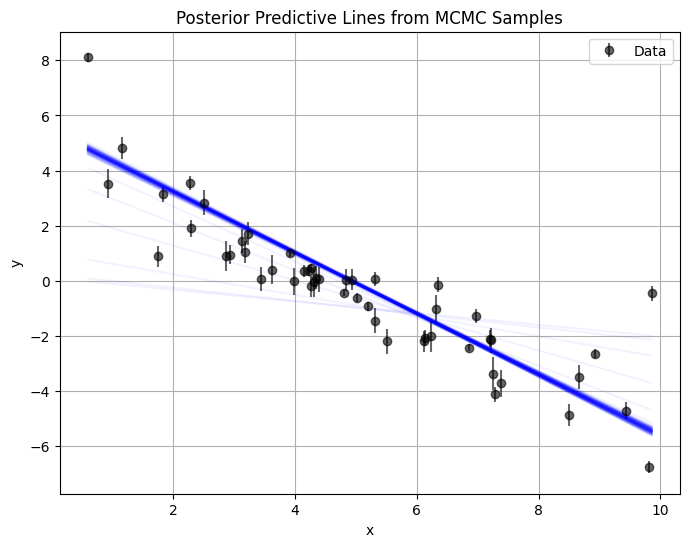

In [ ]:
# Posterior predictive lines
plt.figure(figsize=(8, 6))
plt.errorbar(x_data, y_data, yerr=y_err, fmt='o', color='black', alpha=0.6, label='Data')

# Plot a subset of posterior samples
x_vals = np.linspace(min(x_data), max(x_data), 100)
for i in range(100):
    m, b = samples[np.random.randint(len(samples))]
    y_vals = m * x_vals + b
    plt.plot(x_vals, y_vals, color='blue', alpha=0.05)

plt.xlabel("x")
plt.ylabel("y")
plt.title("MCMC Posterior Predictive Lines")
plt.grid(True)
plt.legend()
plt.show()

# Problem 2: Fitting a Line

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

a) Fit the data using an ensemble sampler of your choice (recommendation: `emcee`)

b) Fit the data using a Hamiltonian Monte Carlo Sampler of your choice (recommendation: `PyMC` or `NumPyro`)

c) Fit the data using a nested sampler of your choice (recommendation: `dynesty`, `UltraNest`)

For all three cases, explicity write down the likelihood function; the `emcee` documentation has a clear explanation of how to do this. For Nested Sampling, you will also need to write a prior transform function; the `dynesty` documentation has a clear explanation of how to do this. Play around with using different priors (e.g. Gaussian, Uniform, Log-Uniform) to get a feel for the syntax of the different packages.

100%|██████████| 5000/5000 [00:06<00:00, 742.23it/s]


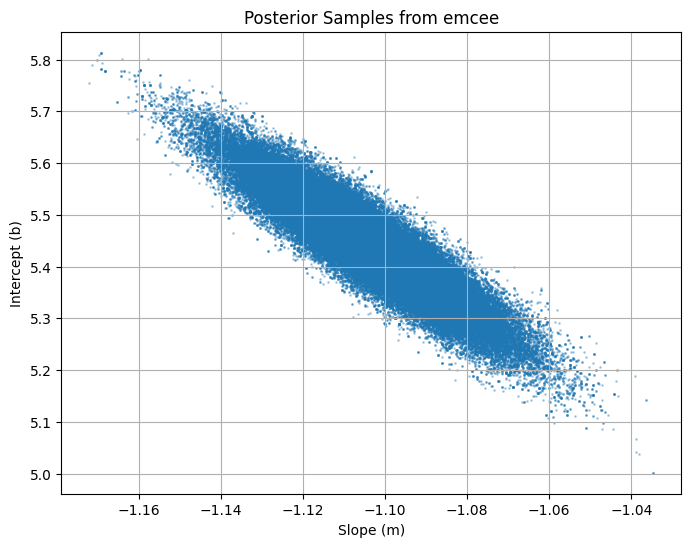

In [15]:
# 2.a. emcee ensemble sampler

# Log likelihood
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

# Log prior
def log_prior(theta):
    m, b = theta
    if -10.0 < m < 10.0 and -10.0 < b < 10.0:
        return 0.0
    return -np.inf

# Log posterior
def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

# MCMC setup
ndim = 2
nwalkers = 50
initial = np.array([0.5, 0.5]) + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_data, y_data, y_err))
sampler.run_mcmc(initial, 5000, progress=True)

samples = sampler.get_chain(discard=1000, flat=True)

# Plot samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.3)
plt.xlabel("Slope (m)")
plt.ylabel("Intercept (b)")
plt.title("Posterior Samples from emcee")
plt.grid(True)
plt.show()

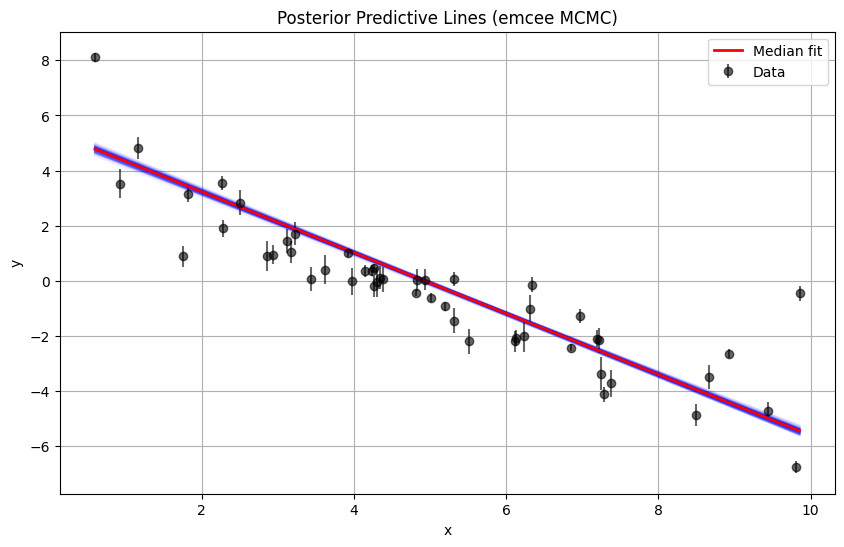

In [16]:
# Now make the plot
# Plot data with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_err, fmt='o', color='black', alpha=0.6, label='Data')

# x values for prediction lines
x_fit = np.linspace(min(x_data), max(x_data), 100)

# Plot 100 randomly chosen lines from the posterior
for i in np.random.choice(len(samples), 100, replace=False):
    m, b = samples[i]
    plt.plot(x_fit, m * x_fit + b, color='blue', alpha=0.05)

# Plot the median fit
m_median, b_median = np.median(samples, axis=0)
plt.plot(x_fit, m_median * x_fit + b_median, color='red', lw=2, label='Median fit')

# Labeling
plt.xlabel("x")
plt.ylabel("y")
plt.title("Posterior Predictive Lines (emcee MCMC)")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# 2.b PyMC/NumPyro Hamiltonian MC
# SKIP TUAH 2.c

In [21]:
# 2.c dynesty
import dynesty

# seed the random number generator
rstate= np.random.default_rng(42069)

In [24]:
# Weighted least squares fit
w = 1 / y_err**2
X = np.vstack((x_data, np.ones_like(x_data))).T
cov = np.linalg.inv(X.T @ np.diag(w) @ X)
params = cov @ (X.T @ np.diag(w) @ y_data)
m_fit, b_fit = params

print(f"Weighted Least Squares Fit: y = {m_fit:.3f} x + {b_fit:.3f}")

Weighted Least Squares Fit: y = -1.104 x + 5.441


In [22]:
# log-likelihood
def loglike(theta):
    m, b, lnf = theta
    model = m * x_data + b
    inv_sigma2 = 1.0 / (y_err**2 + model**2 * np.exp(2 * lnf))
    
    return -0.5 * (np.sum((y_data - model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# prior transform
def prior_transform(utheta):
    um, ub, ulf = utheta
    m = 5.5 * um - 5.
    b = 10. * ub
    lnf = 11. * ulf - 10.
    
    return m, b, lnf

In [23]:
dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=3,
                                        bound='multi', sample='rwalk', rstate=rstate)
dsampler.run_nested()
dres = dsampler.results

676it [00:06, 182.05it/s, batch: 0 | bound: 0 | nc: 17 | ncall: 1529 | eff(%): 33.317 | loglstar:   -inf < -786.980 <    inf | logz: -795.212 +/-  0.127 | dlogz: 784.276 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


16532it [00:39, 422.29it/s, batch: 7 | bound: 28 | nc: 1 | ncall: 335006 | eff(%):  4.778 | loglstar: -17.551 < -12.185 < -12.551 | logz: -23.246 +/-  0.090 | stop:  0.916]        


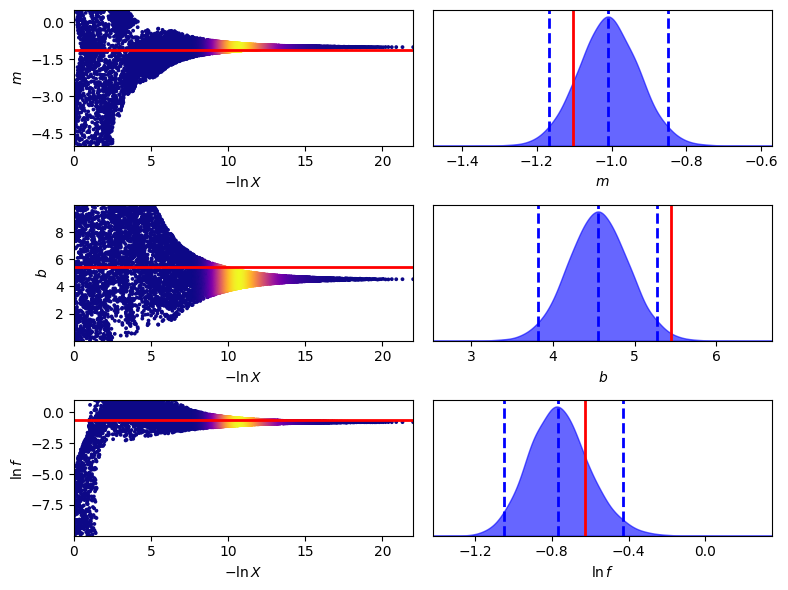

In [29]:
from dynesty import plotting as dyplot

f_true = 0.534

truths = [m_fit, b_fit, np.log(f_true)]
labels = [r'$m$', r'$b$', r'$\ln f$']
fig, axes = dyplot.traceplot(dsampler.results, truths=truths, labels=labels,
                             fig=plt.subplots(3, 2, figsize=(8, 6)))
fig.tight_layout()

# Problem 3: Astrophysics

Select an astrophysical dataset of your choosing. Fit the data using (a) an ensemble sampler, (b) HMC, and (c) Nested Sampling. Verify that the three methods produce equivalent results.